# Introduction
_This blog post is a three-part series. See [part 1 for retrieving the dataset](https://www.feststelltaste.de/finding-tested-code-with-jqassistant/) and [part 2 for the calculation of similarity between test cases](https://www.feststelltaste.de/calculating-the-structural-similarity-of-test-cases/)._

In the previous blog post, we've seen how we can calculate the structural (dis-)similarity between test cases based on the invoked production methods. We manually spotted some test cases that were very similar by searching through the whole dataset. This could get very tedious. So in this blog post, I show how we can partly automate the process of identifying groups of similar test cases as well as how we can visualize those groups. The aim is to find test cases that test the same production code but shouldn't do it. 

_Note: Albeit we use a kind of artificial dataset based on pure unit tests (for simplicity reasons), this data analysis is a very powerful way for spotting test duplications of long-running end-to-end-tests that were written e.g. with the Selenium browser automation framework._

# Dataset
Let's first read in the data from the [previous (dis-)similarity calculation](https://www.feststelltaste.de/calculating-the-structural-similarity-of-test-cases/) with Pandas and have a look at it. Because we have a dataset with multi-level indexes and columns, we have to specify this accordingly with the `index_col` and `header` parameters.

In [1]:
import pandas as pd

distance_df = pd.read_excel(
    "datasets/test_distance_matrix.xlsx",
    index_col=[0,1],
    header=[0,1])
# show only subset of data
distance_df.iloc[:5,:2]

test_type                                                                      AddCommentTest  \
test_method                                              void blankSiteContainsRightComment()   
test_type      test_method                                                                      
AddCommentTest void blankSiteContainsRightComment()                                       0.0   
               void blankSiteContainsRightCreationTime()                                  0.0   
               void blankSiteContainsRightUser()                                          0.0   
               void failsAtCommentNull()                                                  0.0   
               void failsAtCreatorNull()                                                  0.0   

test_type                                                                                           
test_method                                              void blankSiteContainsRightCreationTime()  
test_type      test_method                                                                          
AddCommentTest void blankSiteContainsRightComment()                                            0.0  
               void blankSiteContainsRightCreationTime()                                       0.0  
               void blankSiteContainsRightUser()                                               0.0  
               void failsAtCommentNull()                                                       0.0  
               void failsAtCreatorNull()                                                       0.0

Our dataset shows the cosine distances between all unit test cases (`test_method`) respectively to the called production methods. That means if two test cases invoke absolutely the same production methods, the distance is 0. If there are only a few calls to the same production method, the distance is something between 0 and 1 depending on the similar number of those calls. If the test cases call completely different production methods, the distance is 1.

We've spotted some interesting test cases manually and discussed these in detail in the [previous blog post](https://www.feststelltaste.de/calculating-the-structural-similarity-of-test-cases/#Discussion). Now we want to do this a little bit more automated. Let's visualize the data first to see what we've achieved so far.

# Basic Visualization
A quick way to visualize a distance matrix is using a heat map plot. Fortunately, the library `seaborn` provides a nice little method that we can use to visualize our matrix `distance_df` without any hassle. We just remove the labeling for both axes to get a  better view of the data.

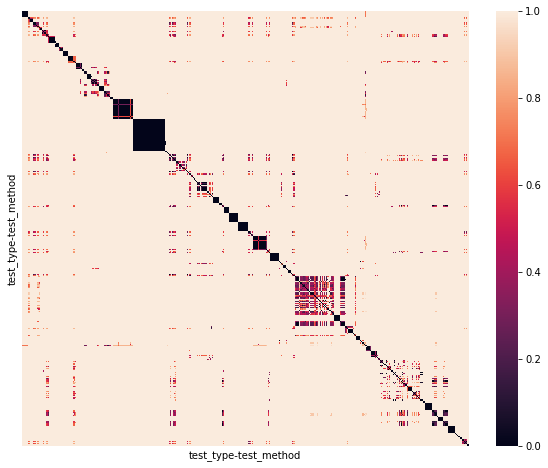

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=[10,8])
sns.heatmap(
    distance_df,
    xticklabels=False,
    yticklabels=False)

This heat map enables us to have a quick look at patterns of the whole data graphically. Black spots show groups of test methods that call the same production methods while light pink colored areas signal disjunct calls to the production code. The ordering of the entries of the heat map is alphabetically by the class names of the test methods and those class names tend to begin with the same prefix (like `Comment` or `Todo`).

Let's have a closer look at the upper left corner of the heat map. It shows the ten first entries of the matrix with the test classes `AddCommentTest` and `AddSchedulingDateTest`. 

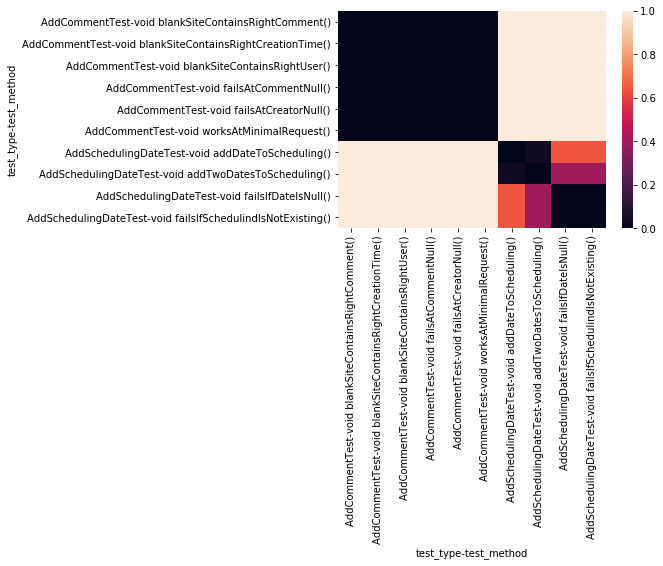

In [3]:
sns.heatmap(distance_df.iloc[:10,:10])

**Discussion**  
The color for the distance of the test methods of the `AddCommentTest` class is deeply dark. That means that the tests in the test class are absolutely similar regarding their structure. If our goal would be the reduction of test code, we could think about merging some test cases together or using some kind of parametrized test execution to avoid duplications.

In contrast, the `AddSchedulingDateTest` shows a more diverse coloring: The test methods `addDateToScheduling` and `addTwoDatesToScheduling` are structurally almost identical (given that one test just adds another date, this makes perfect sense). The more orange colored test `failsIfSchedlindIdIsNotExisting` could be a reason (beneath the typo) for further investigations because it differs almost too much from the other test cases. Maybe this test case can be moved to a more dedicated test class (for checking the correct generation of ids in our case).

# Advanced Visualization
Unfortunately, the 422x422 big distance matrix `distance_df` isn't a good way to spot similarities very efficiently. There are areas of test similarities that don't occur along the diagonal. Fortunately, there are many ways to improve this situation. 

In this blog post, we want to break down the multidimensional result into a two dimensional  representation using multidimensional scaling (MDS). MDS tries to find a representation of our 422-dimensional data set into a two-dimensional space while retaining the distance information between all data points (= test methods). We can use the machine learning library scikit-learn that provides an implementation for multidimensional scaling out of the box. 

Pandas' `DataFrame` just integrates very nicely with the `MDS` module of scikit-learn, too. So we just have to say that we want to use our precomputed dissimilarity matrix `distance_df` as measures for the distance information. We then can let `MDS` figure out a suitable two-dimensional representation of our dataset as well as a suitable transformation by using the `fit_transform` method.

In [4]:
from sklearn.manifold import MDS

# uses a fixed seed for random_state for reproducibility
model = MDS(dissimilarity='precomputed', random_state=10)
# this could take some seconds
distance_df_2d = model.fit_transform(distance_df)
distance_df_2d[:5]

array([[-0.02495802,  0.10768622],
       [ 0.34902428,  0.58676902],
       [-0.0249776 ,  0.10768132],
       [-0.26850959,  0.32472212],
       [-0.02497707,  0.10768145]])

Next, we plot the now two-dimensional matrix with `matplotlib`. We colorize all data points according to the name of the test classes (= the first level of `distance_df`'s index). We can achieve this by assigning each type to a number within 0 and 1 (`relative_index`) and draw a color from a predefined color spectrum ([`cm.hsv`](https://matplotlib.org/examples/color/colormaps_reference.html) in this case) for each type. With this, each test class gets its own color. This enables us to quickly reason about test classes that belong together structurally.

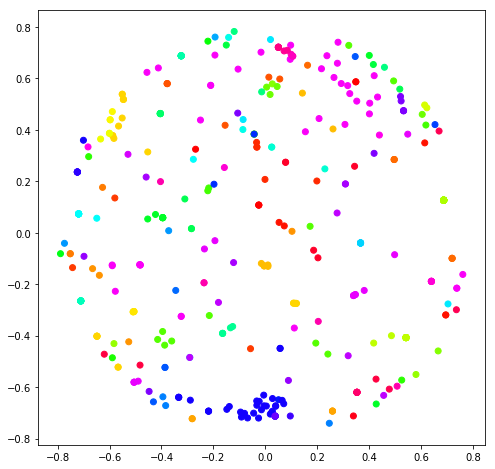

In [5]:
%matplotlib inline
from matplotlib import cm
import matplotlib.pyplot as plt

# brew some colors
relative_index = distance_df.index.labels[0].values() / distance_df.index.labels[0].max()
colors = [x for x in cm.hsv(relative_index)]

# plot the 2D matrix with colors
plt.figure(figsize=(8,8))
x = distance_df_2d[:,0]
y = distance_df_2d[:,1]
plt.scatter(x, y, c=colors)

**Discussion**

We now have the visual information about test methods that call similar production code in 2D.

* Groups of data points of the same color (like the blue colored ones in the lower middle) show that there is a high cohesion of test methods within the test classes that test the corresponding production code.
* Groups of data points with mixed colored data points (like in the upper middle) show test methods from different test classes that call the similar production code. 

With this representation, we can have a look at the various groups to check if the groupings are OK or if we have to restructure some test cases because of too much similarity or confusion of responsibilities.

# Clustering
Let's quickly find both types of groupings programmatically by using another machine learning technique: density-based clustering! With this technique, we can let find data points that are very close together automatically. Again, we can use scikit-learn with its  `DBSCAN` implementation to identify data points that are close together. We plot this information into the plot above to visualize dense groups of data.

For the parameters `eps` (~ maximal distance between the data points so that they are seen as a group) and `min_samples` (~ minimal distance between the data points to be considered as groups), we choose the right values in an iterative manner until we've got the groupings that we would otherwise have identified visually.

In [6]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.08, min_samples=10)
clustering_results = dbscan.fit(distance_df_2d)
clustering_results

DBSCAN(algorithm='auto', eps=0.08, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=10, n_jobs=1, p=None)

We plot all data points of our distance matrix together with the found members of clusters (`components_`) in one scatter plot.

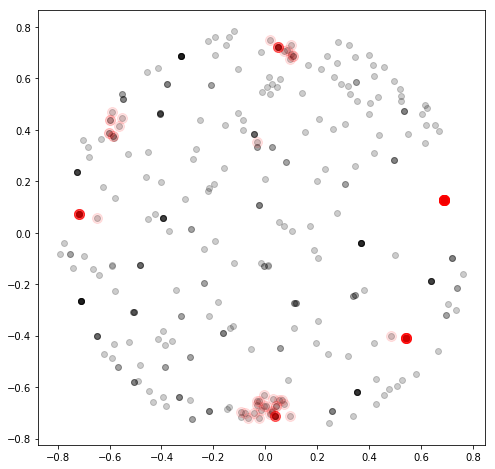

In [7]:
plt.figure(figsize=(8,8))
cluster_members = clustering_results.components_

# plot all data points
plt.scatter(x, y, c='k', alpha=0.2)

# plot cluster members
plt.scatter(
    cluster_members[:,0],
    cluster_members[:,1],
    c='r', s=100, alpha=0.1)

The scatter plot confirms what we've seen as humans with our eyes: There are some groupings that belong together by forming a dense cluster. We cann access these data points e. g. by their cluster labels `labels_` and throw away all non-cluster data points which label's value is `-1`:

In [8]:
clustered_tests = pd.DataFrame(index=distance_df.index)
clustered_tests['cluster'] = clustering_results.labels_
cohesive_tests = clustered_tests[clustered_tests.cluster != -1]
cohesive_tests.head()

cluster
test_type          test_method                                     
AddSchedulingTest  void add2EmptySchedulingWidgetsToSite()        0
                   void addEmptySchedulingWidgetToSite()          0
                   void failsIfPositionIsNull()                   0
AddTodoTest        void addedTodoIsPersisted()                    4
CommentGatewayTest void readFailsOnNullSite()                     1

We now can take a look at various metrics like the number of classes that declare those methods (`nunique`) and the number of cluster members aka test methods (`count`).

In [9]:
test_methods_and_classes_per_cluster = \
  cohesive_tests.reset_index() \
    .groupby("cluster").test_type \
    .agg({"nunique", "count"})
test_methods_and_classes_per_cluster.head()

,nunique,count
cluster,,
0,7,10
1,3,16
2,1,19
3,1,31
4,7,17


We can also see which test classes belong to a cluster.

In [10]:
test_classes = cohesive_tests.reset_index().groupby("cluster").test_type.apply(set)
test_classes

cluster
0    {ReportAbuseTest, GetSchedulingTest, DeleteTod...
1    {CommentsResourceTest, CommentResourceTest, Co...
2                                     {CreateSiteTest}
3                                 {CreateTimeDiffTest}
4    {TodolistResourceTest, GetTodoListTest, TodosR...
5                                        {GetSiteTest}
6    {SchedulingResourceTest, SchedulingGatewayTest...
Name: test_type, dtype: object

If we join both DataFrames, we get a nice summary of clusters with test classes we should have a deeper look into.

In [11]:
test_analysis_result = test_methods_and_classes_per_cluster.join(test_classes)
test_analysis_result

,nunique,count,test_type
cluster,,,
0,7,10,"{ReportAbuseTest, GetSchedulingTest, DeleteTod..."
1,3,16,"{CommentsResourceTest, CommentResourceTest, Co..."
2,1,19,{CreateSiteTest}
3,1,31,{CreateTimeDiffTest}
4,7,17,"{TodolistResourceTest, GetTodoListTest, TodosR..."
5,1,12,{GetSiteTest}
6,6,32,"{SchedulingResourceTest, SchedulingGatewayTest..."


For a more actionable representation of our findings, let's print the results in a good old, console-like way.

In [12]:
def print_results(series):
    print(
        "Cluster {} contains {} test methods in {} test classes."\
        .format(series.name, series['count'], series['nunique']))
    print("  The test classes are:")
    for test_class in series['test_type']:
        print("    -{}".format(test_class))
    print("-"*60)
    
test_analysis_result.apply(print_results, axis=1);

Cluster 0 contains 10 test methods in 7 test classes.
  The test classes are:
    -ReportAbuseTest
    -GetSchedulingTest
    -DeleteTodoListTest
    -AddSchedulingTest
    -DownloadFileTest
    -GetSchedulingsTest
    -DeleteTodoTest
------------------------------------------------------------
Cluster 1 contains 16 test methods in 3 test classes.
  The test classes are:
    -CommentsResourceTest
    -CommentResourceTest
    -CommentGatewayTest
------------------------------------------------------------
Cluster 2 contains 19 test methods in 1 test classes.
  The test classes are:
    -CreateSiteTest
------------------------------------------------------------
Cluster 3 contains 31 test methods in 1 test classes.
  The test classes are:
    -CreateTimeDiffTest
------------------------------------------------------------
Cluster 4 contains 17 test methods in 7 test classes.
  The test classes are:
    -TodolistResourceTest
    -GetTodoListTest
    -TodosResourceTest
    -TodoResourceTes

**Discussion**  
With this list, we see e.g. that there is some mixing in cluster 0. Based on the pure test classes' names, we can see that the test methods test the same production code, but are clearly not alike regarding their functionality. This is a cluster that needs some refactoring. We can also have a deeper look into clusters 4 and 6 because the contained test classes test potentially the same production code which shows that

# Conclusion
What a trip! We've started from a data set that showed us the invocations of production methods by test methods (using [jQAssistant](https://jqassistant.org/)) in the [first part](https://www.feststelltaste.de/finding-tested-code-with-jqassistant/). We also went our way deep through the three mathematical / machine learning techniques `cosine_distances` (in the [second part](https://www.feststelltaste.de/calculating-the-structural-similarity-of-test-cases/)) as well as `MDS` and `DBSCAN` in this post. Finally, we've found out which different test class classes test the same production code. The result is a helpful starting point for reorganizing test cases.

In general, we saw how we can transform software specific problems to questions that can be answered by using standard Data Science tooling. Knowing that this is possible opens up the way for us for a more data-centric thinking to provide real, actionable insights instead of pure guessing. 